# Q. #2

In [1]:
# Import all the functions used in part 1
from era_okid_tools import *
prob = 2

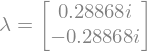

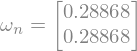

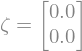

In [2]:
# Set seed for consistent results
rng = np.random.default_rng(seed = 100)

# Simulation dimensions
noises = (0.001, 0.01, 0.1, 0.5) # Standard deviations of noises
cases = 3 # Number of cases
n = 2 # Number of states
r = 1 # Number of inputs
m = 2 # Number of measurements
t_max = 50 # Total simulation time
dt = 0.1 # Simulation timestep duration
nt = int(t_max/dt) # Number of simulation timesteps

# Simulation time
train_cutoff = int(20/dt) + 1
t_sim = np.linspace(0, t_max, nt + 1)
t_train = t_sim[:train_cutoff]
t_test = t_sim
nt_train = train_cutoff
nt_test = nt

# Problem parameters
theta_0 = 0.5 # Angular velocity
k = 10 # Spring stiffness
mass = 1 # Point mass

# State space model
A_c = np.array([[0, 1], [theta_0**2 - k/mass, 0]])
B_c = np.array([[0], [1]])
C = np.eye(2)
D = np.array([[0], [1]])
A, B = c2d(A_c, B_c, dt)
eig_A = spla.eig(A_c)[0] # Eigenvalues of true system
etch(f"\lambda", eig_A)
etch(f"\omega_{{n}}", np.abs(eig_A))
etch(f"\zeta", -np.cos(np.angle(eig_A)))

# True simulation values
X_0_sim = np.zeros([n, 1]) # Zero initial condition
U_sim = np.zeros([cases, r, nt]) # True input vectors
U_sim[0] = rng.normal(0, 0.1, [r, nt]) # True input for case 1
U_sim[1] = spsg.square(2*np.pi*5*t_sim[:-1]) # True input for case 2
U_sim[2] = np.cos(2*np.pi*2*t_sim[:-1]) # True input for case 3
X_sim = np.zeros([cases, n, nt + 1]) # True state vectors
Z_sim = np.zeros([cases, m, nt]) # True observation vectors
W_sim = np.zeros([len(noises), cases, m, nt]) # Measurement noise vectors

# Separation into train and test data
U_train = U_sim[0, :r, :train_cutoff] # Train input vector
U_test = U_sim # Test input vectors
X_train = np.zeros([len(noises), n, nt_train]) # Train state vector
X_test = np.zeros([len(noises), cases, n, nt_test + 1]) # Test state vectors
Z_train = np.zeros([len(noises), m, nt_train]) # Train observation vector
Z_test = np.zeros([len(noises), cases, m, nt_test]) # Test observation vectors

In [3]:
# OKID logistics
order = 50 # Order of OKID algorithm, number of Markov parameters to identify after the zeroeth
alpha, beta = 15, 20 # Number of block rows and columns in Hankel matrices
n_era = 2 # Number of proposed states
X_0_okid = np.zeros([n_era, 1]) # Zero initial condition

In [4]:
# OKID System Markov parameters
Y_okid = np.zeros([len(noises), order + 1, m, r])
# OKID Observer Markov Gain parameters
Y_og_okid = np.zeros([len(noises), order, m, m])
# OKID state vector, drawn from state space model derived from OKID/ERA
X_okid_train = np.zeros([len(noises), n_era, nt_train + 1])
X_okid_test = np.zeros([len(noises), cases, n_era, nt_test + 1])
# OKID observations, drawn from state space model derived from OKID/ERA
Z_okid_train = np.zeros([len(noises), n_era, nt_train])
Z_okid_test = np.zeros([len(noises), cases, n_era, nt_test])
# Singular values of the Hankel matrix constructed through OKID Markov parameters
S_okid = np.zeros([len(noises), min(alpha*m, beta*r)])
eig_A_okid = np.zeros([len(noises), n_era], dtype = complex)

A_okid = np.zeros([len(noises), n_era, n_era])
B_okid = np.zeros([len(noises), n_era, r])
C_okid = np.zeros([len(noises), m, n_era])
D_okid = np.zeros([len(noises), m, r])
G_okid = np.zeros([len(noises), m, m])

Rank of H(0): 20
Rank of H(1): 20
Rank of H(0): 20
Rank of H(1): 20
Rank of H(0): 20
Rank of H(1): 20
Rank of H(0): 20
Rank of H(1): 20


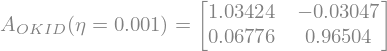

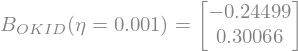

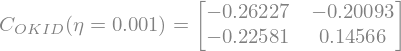

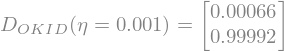

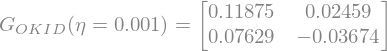

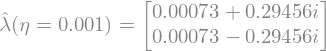

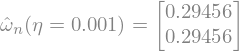

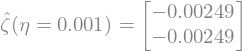

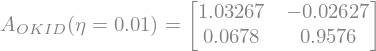

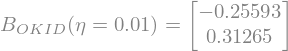

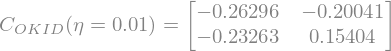

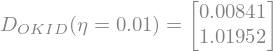

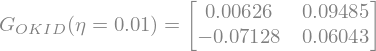

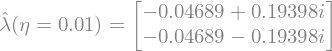

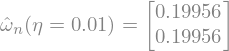

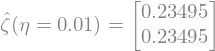

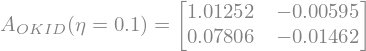

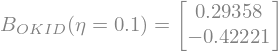

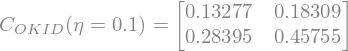

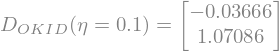

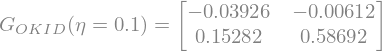

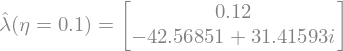

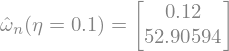

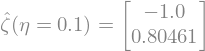

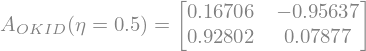

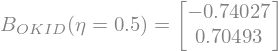

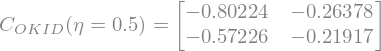

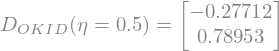

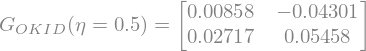

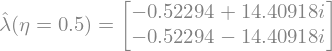

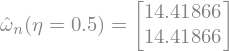

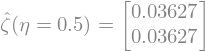

In [5]:
# Simulation
for i, j in it.product(range(cases), range(len(noises))):
    W_sim[j, i] = rng.normal(0, noises[j], size = Z_sim[i].shape)
    X_sim[i], Z_sim[i] = sim_ss(A, B, C, D, X_0 = X_0_sim, U = U_sim[i], nt = nt)
    if i == 0:
        # Split between train and test data for case 1
        X_train[j], Z_train[j] = \
            X_sim[i, :, :train_cutoff], (Z_sim[i, :, :train_cutoff] + W_sim[j, i, :, :train_cutoff])
        # Identify System Markov parameters and Observer Gain Markov parameters
        Y_okid[j], Y_og_okid[j] = \
            okid(Z_train[j], U_train,
                 l_0 = order, alpha = alpha, beta = beta, n = n_era)
        # Identify state space model using System Markov parameters for ERA
        A_okid[j], B_okid[j], C_okid[j], D_okid[j], S_okid[j] = \
            era(Y_okid[j], alpha = alpha, beta = beta, n = n_era)
        # Construct observability matrix
        O_p_okid = np.array([C_okid[j] @ np.linalg.matrix_power(A_okid[j], i)
                             for i in range(order)])
        # Find observer gain matrix
        G_okid[j] = spla.pinv2(O_p_okid.reshape([order*m, n_era])) @ Y_og_okid[j].reshape([order*m, m])
        X_okid_train[j], Z_okid_train[j] = \
            sim_ss(A_okid[j], B_okid[j], C_okid[j], D_okid[j],
                   X_0 = X_0_okid, U = U_train, nt = nt_train)
        # Display outputs
        etch(f"A_{{OKID}}(\eta = {noises[j]})", A_okid[j])
        etch(f"B_{{OKID}}(\eta = {noises[j]})", B_okid[j])
        etch(f"C_{{OKID}}(\eta = {noises[j]})", C_okid[j])
        etch(f"D_{{OKID}}(\eta = {noises[j]})", D_okid[j])
        etch(f"G_{{OKID}}(\eta = {noises[j]})", G_okid[j])
        # Calculate and display eigenvalues
        eig_A_okid[j] = spla.eig(d2c(A_okid[j], B_okid[j], dt)[0])[0] # Eigenvalues of identified system
        etch(f"\hat{{\lambda}}(\eta = {noises[j]})", eig_A_okid[j])
        etch(f"\hat{{\omega}}_{{n}}(\eta = {noises[j]})", np.abs(eig_A_okid[j]))
        etch(f"\hat{{\zeta}}(\eta = {noises[j]})", -np.cos(np.angle(eig_A_okid[j])))
    X_test[j, i], Z_test[j, i] = \
        X_sim[i], (Z_sim[i] + W_sim[j, i])
    X_okid_test[j, i], Z_okid_test[j, i] = \
        sim_ss(A_okid[j], B_okid[j], C_okid[j], D_okid[j],
               X_0 = X_0_okid, U = U_test[i], nt = nt_test)

The eigenvalues are decently closely identified when the noise value is less than $\eta < 0.1$
(though the noise results in the presence of a bit of damping in the estimation).
However, for $\eta \ge 0.1$, the eigenvalue estimation totally collapses; for $\eta = 0.1$,
an unstable (positive) eigenvalue appears for $\eta = 0.5$, the estimation is essentially meaningless.

In [6]:
RMS_train = np.zeros([len(noises), m])
RMS_test = np.zeros([len(noises), cases, m])
for j in range(len(noises)):
    RMS_train[j] = np.sqrt(np.mean((Z_okid_train[j] - Z_train[j])**2, axis = 1))
    print(f"RMS Error of sim. for system found via OKID for train data, noise std.dev. = {noises[j]}: {RMS_train[j]}")
    for i in range(cases):
        RMS_test[j, i] = np.sqrt(np.mean((Z_okid_test[j, i] - Z_test[j, i])**2, axis = 1))
        print(f"RMS Error of sim. for system found via OKID for test data, noise std.dev. = {noises[j]}, case {i}: {RMS_test[j, i]}")

RMS Error of sim. for system found via OKID for train data, noise std.dev. = 0.001: [0.00578665 0.0017917 ]
RMS Error of sim. for system found via OKID for test data, noise std.dev. = 0.001, case 0: [0.03492325 0.00629567]
RMS Error of sim. for system found via OKID for test data, noise std.dev. = 0.001, case 1: [0.53425415 0.1306717 ]
RMS Error of sim. for system found via OKID for test data, noise std.dev. = 0.001, case 2: [0.01987407 0.0054457 ]
RMS Error of sim. for system found via OKID for train data, noise std.dev. = 0.01: [0.12237801 0.01961363]
RMS Error of sim. for system found via OKID for test data, noise std.dev. = 0.01, case 0: [0.38590541 0.10504539]
RMS Error of sim. for system found via OKID for test data, noise std.dev. = 0.01, case 1: [6.57187074 1.56251519]
RMS Error of sim. for system found via OKID for test data, noise std.dev. = 0.01, case 2: [0.14059243 0.04006846]
RMS Error of sim. for system found via OKID for train data, noise std.dev. = 0.1: [0.14240184 0.28

The RMS error for the test cases remains relatively low for $\eta < 0.1$,
but explodes due to the unstable estimated eigenvalue for $\eta = 0.1$.

In [7]:
# Eigenvalue plots
fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle(f"[{prob}] Eigenvalues", fontweight = "bold")

ax.plot(np.real(eig_A), np.imag(eig_A),
         "o", mfc = "None")
for j in range(len(noises)):
    ax.plot(np.real(eig_A_okid[j]), np.imag(eig_A_okid[j]),
            "o", mfc = "None")

fig.legend(labels = ("True", *[f"OKID ($\eta$ = {noise})" for noise in noises]),
           bbox_to_anchor = (1, 0.5), loc = 6)
fig.savefig(figs_dir / f"midterm_{prob}_eigval.pdf",
            bbox_inches = "tight")

# Singular Value plots
fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle(f"[{prob}] Singular Values", fontweight = "bold")

for j in range(len(noises)):
    ax.plot(np.linspace(1, len(S_okid[j]), len(S_okid[j])), S_okid[j],
            "o", mfc = "None")
plt.setp(ax, xlabel = f"Singular Value", ylabel = f"Value",
         xticks = np.arange(1, S_okid.shape[-1] + 1))

fig.legend(labels = [f"OKID ($\eta$ = {noise})" for noise in noises],
           bbox_to_anchor = (1, 0.5), loc = 6)
fig.savefig(figs_dir / f"midterm_{prob}_singval.pdf",
            bbox_inches = "tight")

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

As shown by the singular value plot, the singular values remain disjoint for $\eta < 0.1$,
but as $\eta$ increases, the singular values converge and the dropoff between the 2nd and 3rd singular values decreases,
making it harder to find the system with an order $n_{ERA}$ = 2.

In [8]:
# Observation plots
ms = 0.5
for i, k in it.product(range(cases), range(len(noises))):
    # Raw observations
    raw_fig, axs = plt.subplots(m, 1,
                                sharex = "col", constrained_layout = True) # type:figure.Figure
    raw_fig.suptitle(f"[{prob}] Observation Responses (Case {i + 1})\n$\eta$ = {noises[k]}",
                     fontweight = "bold")
    if i == 0:
        for j in range(m):
            axs[j].plot(t_sim[:-1], Z_sim[i, j])
            axs[j].plot(t_train, Z_train[k, j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[train_cutoff:-1], Z_test[k, i, j, train_cutoff:],
                        "s", ms = ms, mfc = "None")
            axs[j].plot(t_train, Z_okid_train[k, j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[train_cutoff:-1], Z_okid_test[k, i, j, train_cutoff:],
                        "D", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        raw_fig.legend(labels = ["True", "Train", "Test",
                                 "OKID\n(Train)", "OKID\n(Test)"],
                       bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        for j in range(m):
            axs[j].plot(t_sim[:-1], Z_sim[i, j])
            axs[j].plot(t_test[:-1], Z_test[k, i, j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[:-1], Z_okid_test[k, i, j],
                        "s", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        raw_fig.legend(labels = ["True", "Test", "OKID\nTest"],
                       bbox_to_anchor = (1, 0.5), loc = 6)
    raw_fig.savefig(figs_dir / f"midterm_{prob}_obs_case{i + 1}_noise{k}.pdf",
                    bbox_inches = "tight")

    # Observation error
    err_fig, axs = plt.subplots(m, 1,
                                sharex = "col", constrained_layout = True) # type:figure.Figure
    err_fig.suptitle(f"[{prob}] Observation Error (Case {i + 1})\n$\eta$ = {noises[k]}",
                     fontweight = "bold")
    if i == 0:
        for j in range(m):
            axs[j].plot(t_train, np.abs(Z_okid_train[k, j] - Z_train[k, j]),
                        c = "C1")
            axs[j].plot(t_test[train_cutoff:-1], np.abs(Z_okid_test[k, i, j, train_cutoff:] - Z_test[k, i, j, train_cutoff:]),
                        "o", ms = ms, mfc = "None", c = "C0")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        err_fig.legend(labels = ["OKID\nTrain", "OKID\nTest"],
                       bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        for j in range(m):
            axs[j].plot(t_test[:-1], np.abs(Z_okid_test[k, i, j] - Z_test[k, i, j]),
                        "o", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        err_fig.legend(labels = ["OKID\nTest"],
                       bbox_to_anchor = (1, 0.5), loc = 6)
    err_fig.savefig(figs_dir / f"midterm_{prob}_obs-error_case{i + 1}_noise{k}.pdf",
                    bbox_inches = "tight")

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

* The estimation remains pretty accurate, for both training and testing, in all cases for $\eta = 0.001$.
* The estimation doesn't do as well even in the training data when $\eta = 0.01$,
as there is some deviation from the true training observations after the first few seconds.
* The estimation fails entirely for $\eta > 0.1$,
which makes sense since the observation signal is dominated by the noise in such cases
and the true observation data is nearly entirely obscured.